In [1]:
import requests
from bs4 import BeautifulSoup
import csv
import json
import re

base_url = 'https://www.newegg.com/GPUs-Video-Graphics-Cards/SubCategory/ID-48/Page-{}'

# Open the CSV file in write mode
with open('newegg_data.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)

    # Write the header row
    writer.writerow(['ItemID', 'Title', 'Branding', 'Rating', 'Rating Count', 'Price', 'Shipping', 'Image URL', 'Total Price', 'Detailed Information'])

    # Iterate through the pages
    for page in range(1, 101):
        url = base_url.format(page)
        response = requests.get(url)

        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')

            # Extract and process the data from the page
            products = soup.select('.item-cell')
            for product in products:
                item_id_element = product.select_one('li strong:contains("Item #:")')
                item_id = item_id_element.next_sibling.strip() if item_id_element else None

                if not item_id:
                    item_href_element = product.select_one('a.item-img')
                    item_href = item_href_element['href'] if item_href_element else None
                    item_id = item_href.split('/p/')[-1] if item_href else None


                title_element = product.select_one('.item-title')
                title = title_element.text.strip() if title_element else None

                branding_element = product.select_one('.item-brand img')
                branding = branding_element['title'] if branding_element else None

                rating_element = product.select_one('.item-rating')
                rating_text = rating_element.select_one('i')['aria-label'].split(' out of ')[0] if rating_element else None
                rating = float(rating_text.split(' ')[1]) if rating_text else None

                rating_count_element = product.select_one('.item-rating-num')
                rating_count = rating_count_element.text.strip().replace('(', '').replace(')', '') if rating_count_element else None

                price_element = product.select_one('.price-current strong')
                price = price_element.text.strip() if price_element else None

                # Convert price to a number
                price = float(''.join(filter(str.isdigit, price))) if price else 0

                shipping_element = product.select_one('.price-ship')
                shipping = shipping_element.text.strip() if shipping_element else None

                # Process shipping information
                if 'free' in shipping.lower():
                    shipping = 'Free Shipping'
                    shipping_cost = 0
                else:
                    try:
                        shipping_cost_match = re.search(r'\$([\d.]+)', shipping)
                        shipping_cost = float(shipping_cost_match.group(1)) if shipping_cost_match else 0
                    except ValueError:
                        shipping_cost = 0

                # Calculate total price
                total_price = price + shipping_cost

                # Extract detailed information
                details_element = product.select_one('.item-features')
                details = {}
                if details_element:
                    for li in details_element.find_all('li'):
                        strong = li.find('strong')
                        if strong:
                            key = strong.text.strip().rstrip(':')
                            if key in ['Max Resolution', 'DisplayPort', 'HDMI', 'DirectX', 'Model']:
                                value = li.get_text(strip=True).split(':', 1)[1].strip()
                                details[key] = value
                            
                details_json = json.dumps(details, ensure_ascii=False)

                # Extract image URL
                image_element = product.select_one('.item-img img')
                image_url = image_element['src'] if image_element else None

                # Write the data to the CSV file
                writer.writerow([item_id, title, branding, rating, rating_count, price, shipping, image_url, total_price, details_json])

                # Print the data (optional)
                print('Page:', page)
                print('Item ID:', item_id)
                print('Title:', title)
                print('Branding:', branding)
                print('Rating:', rating)
                print('Rating Count:', rating_count)
                print('Price:', price)
                print('Shipping:', shipping)
                print('Image URL:', image_url)
                print('Total Price:', total_price)
                print('Detailed Information:', details_json)
                print('---')
        else:
            print('Failed to retrieve the webpage:', response.status_code)

print('Data saved to newegg_data.csv file.')


/Users/hoanguyen/opt/anaconda3/envs/ban438/lib/python3.10/site-packages/soupsieve/css_parser.py:876: FutureWarning: The pseudo class ':contains' is deprecated, ':-soup-contains' should be used moving forward.
  warnings.warn(


Page: 1
Item ID: N82E16814932580
Title: GIGABYTE GeForce RTX 4070 Ti GAMING OC 12G Graphics Card, 3x WINDFORCE Fans, 12GB 192-bit GDDR6X, GV-N407TGAMING OC-12GD Video Card
Branding: GIGABYTE
Rating: 4.9
Rating Count: 59
Price: 859.0
Shipping: Free Shipping
Image URL: https://c1.neweggimages.com/ProductImageCompressAll300/14-932-580-15.jpg
Total Price: 859.0
Detailed Information: {"Max Resolution": "7680 x 4320", "DisplayPort": "3 x DisplayPort 1.4", "HDMI": "1 x HDMI 2.1"}
---
Page: 1
Item ID: N82E16814932561
Title: GIGABYTE Gaming GeForce RTX 4080 16GB GDDR6X PCI Express 4.0 x16 ATX Video Card GV-N4080GAMING OC-16GD
Branding: GIGABYTE
Rating: 4.3
Rating Count: 109
Price: 1183.0
Shipping: Free Shipping
Image URL: https://c1.neweggimages.com/ProductImageCompressAll300/14-932-561-23.jpg
Total Price: 1183.0
Detailed Information: {"Max Resolution": "7680 x 4320", "DisplayPort": "3 x DisplayPort 1.4a", "HDMI": "1 x HDMI 2.1", "DirectX": "DirectX 12"}
---
Page: 1
Item ID: 9SIB86XH2K2757
Titl

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
df = pd.read_csv('newegg_data.csv')

# Count the null values in each column
null_counts = df.isnull().sum()
row_count = df.shape[0]

# Check for duplicated rows
duplicates = df.duplicated()
# Count the number of duplicated rows
num_duplicates = duplicates.sum()
# Print the null value counts
print(null_counts)
print('row count:', row_count )
print('duplicate_count:', num_duplicates)


ItemID                     0
Title                      1
Branding                 121
Rating                  1584
Rating Count            1584
Price                      0
Shipping                  14
Image URL                  0
Total Price                0
Detailed Information       0
dtype: int64
row count: 3604
duplicate_count: 9


In [7]:

#import csv into db
# e dung mac k co SQL nen ko co user name + password 
import sqlalchemy as db
server = 'localhost'
database = 'your_database_name'
username = 'your_username'
password = 'your_password'
table_name = 'your_table_name'
schema = 'your_schema_name'  
# Create SQLAlchemy engine for SQL Server
engine = create_engine(f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server')
connection = engine.connect()
df.to_sql(name=table_name, con=engine, schema=schema, if_exists='replace', index=False)


ModuleNotFoundError: No module named 'pymysql'

/var/folders/fx/38wtbyns05ddtmg43f48cf5m0000gn/T/ipykernel_97649/1358270956.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(brand_counts.index, rotation=45, ha='right')


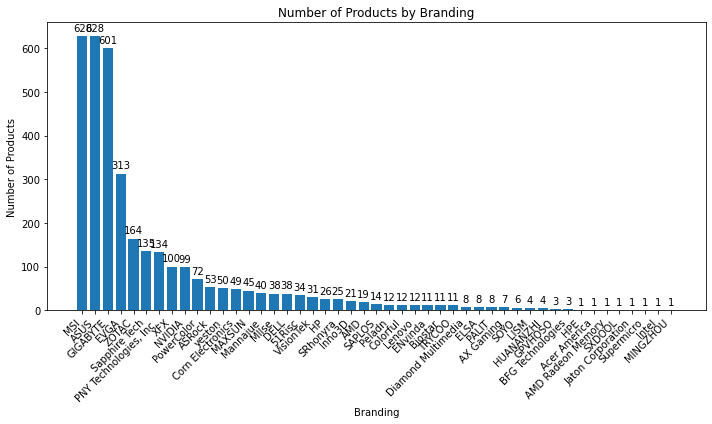

In [36]:
#Visualization 1: Number of Products per Brand

# Group by Branding and count the number of products
brand_counts = df['Branding'].value_counts()

# Plot a bar chart of the brand counts
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size as needed
bar_plot = ax.bar(brand_counts.index, brand_counts.values)

# Set the x-axis labels to be rotated for better visibility
ax.set_xticklabels(brand_counts.index, rotation=45, ha='right')

# Add labels to the bars
for rect in bar_plot:
    height = rect.get_height()
    ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.xlabel('Branding')
plt.ylabel('Number of Products')
plt.title('Number of Products by Branding')
plt.tight_layout()  # Adjust the spacing between the plot elements
plt.show()


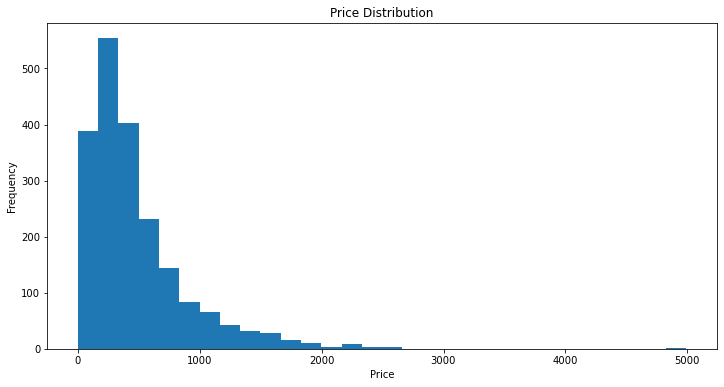

In [50]:
#Price Distribution
# Remove rows with missing price values
df = df.dropna(subset=['Price'])

# Convert Price column to numeric
df['Price'] = pd.to_numeric(df['Price'])

# Set the figure size to make the plot wider
plt.figure(figsize=(12, 6))

# Plot a histogram of the price distribution
plt.hist(df['Price'], bins=30)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution')
plt.show()


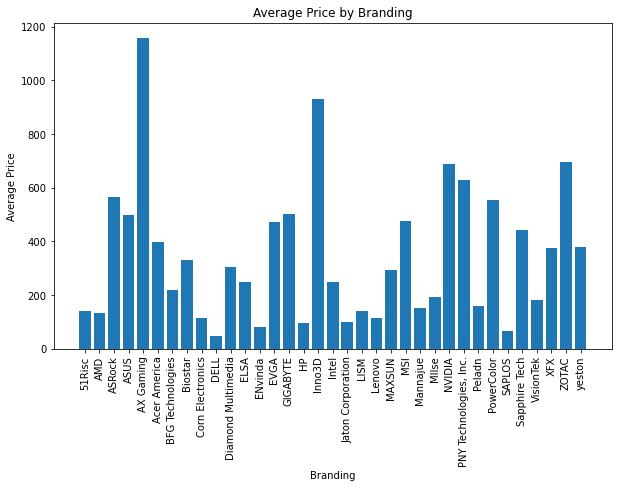

In [45]:
# Group by Branding and calculate the mean price
brand_prices = df.groupby('Branding')['Price'].mean()

# Set the figure size to make the plot wider
plt.figure(figsize=(10, 6))

# Plot a bar chart of the average prices by brand
plt.bar(brand_prices.index, brand_prices.values)
plt.xlabel('Branding')
plt.ylabel('Average Price')
plt.title('Average Price by Branding')
plt.xticks(rotation=90)

plt.show()

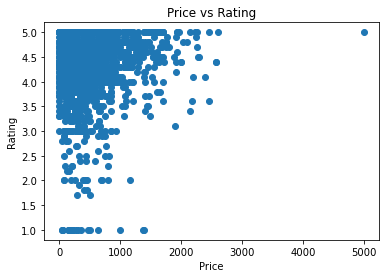

In [43]:
#Relationship between Price vs Rating
# Remove rows with missing rating values
df = df.dropna(subset=['Rating'])

# Convert Rating column to numeric
df['Rating'] = pd.to_numeric(df['Rating'])

# Scatter plot of 
plt.scatter(df['Price'], df['Rating'])
plt.xlabel('Price')
plt.ylabel('Rating')
plt.title('Price vs Rating')
plt.show()
